# Visual-Language Saliency
* In this notebook you can observe (heatmap) the connection between images and texts due to CLIP embeddings
* Subscribe to my channel [@AbstractDL](https://t.me/abstractDL), it is about Deep Learning ;)

In [1]:
#@title Run this cell to prepare all magic
!git clone https://github.com/sberbank-ai/ru-clip.git
!pip install transformers
!pip install pymorphy2
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
import random
from tqdm import tqdm
import numpy as np
from PIL import Image
import requests
import sys
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("ru-clip/")
from clip.evaluate.utils import (
    get_text_batch, get_image_batch, get_tokenizer,
    show_test_images, show_similarity,
    prepare_classes, call_model,
    show_topk_probs,
    load_weights_only,
    get_topk_accuracy,
    show_topk_accuracy
)
from clip.evaluate.tvd import get_text_probs_from_dataset

device = "cuda"
model, args = load_weights_only("ViT-B/32-small")
model = model.to(device).float().eval()
tokenizer = get_tokenizer()
clear_output(True)
print("Done")

Cloning into 'ru-clip'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 70 (delta 29), reused 54 (delta 20), pack-reused 0
Unpacking objects: 100% (70/70), 1.73 MiB | 3.16 MiB/s, done.
     |████████████████████████████████| 55 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 2.4 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=4f9915a6fd7f80f8f3ec6ebb1c2eb952761616d20fb4e68f34623ddf9fa42683
  Stored in directory: /home/razzhigaev/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


ModuleNotFoundError: No module named 'pymorphy2'

100%|██████████| 2000/2000 [01:40<00:00, 19.81it/s]


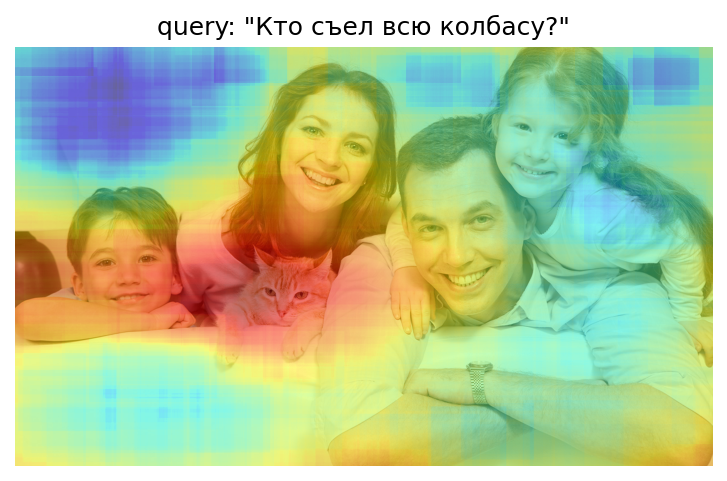

In [ ]:
#@title Run this cell to build a saliency map
picture_url = "https://week.ba/wp-content/uploads/2019/12/porodica-djeca.jpg"#@param {type:"string"}
text = "\u041A\u0442\u043E \u0441\u044A\u0435\u043B \u0432\u0441\u044E \u043A\u043E\u043B\u0431\u0430\u0441\u0443?"#@param {type:"string"}
n_iters = 2000 #@param {type:"integer"}
window = 100 #@param {type:"integer"}

image = Image.open(requests.get(picture_url, stream=True).raw)
dim_y, dim_x = image.size
input_ids, attention_mask = get_text_batch([text], tokenizer, args)
input_ids = input_ids.to(device)
img_input = get_image_batch([image], args.img_transform, args).to(device)
v2 = model.visual_encoder(img_input)
v1 = model.text_encoder(input_ids)
cosine = torch.cosine_similarity(v1,v2).item()
initial_cos = cosine
saliency = np.zeros((dim_x, dim_y))

for _ in tqdm(range(n_iters)):
    im_tensor = np.array(image)
    x = random.randint(0,dim_x)
    y = random.randint(0,dim_y)
    w = random.randint(window,dim_x)
    h = random.randint(window,dim_y)
    h = (w + h) // 2
    im_tensor = im_tensor[max(x - w // 2,0) : min(x + w // 2, dim_x), max(y - h // 2,0) : min(y + h // 2, dim_y),...]
    
    img_input = get_image_batch([Image.fromarray(im_tensor)], args.img_transform, args).to(device)
    v1 = model.text_encoder(input_ids)
    v2 = model.visual_encoder(img_input)
    
    cosine = torch.cosine_similarity(v1,v2).item()
    saliency[max(x - w // 2,0) : min(x + w // 2, dim_x), max(y - h // 2,0) : min(y + h // 2, dim_y),...] += (cosine - initial_cos) / (im_tensor.shape[0] * im_tensor.shape[1])

im_tensor = np.array(image)
plt.figure(dpi=150)
plt.imshow(im_tensor)
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title(f'query: \"{text}\"')
plt.axis("off")
plt.show()
    